# Chapter13 :Loading and Preprocessing Data with TensorFlow

Code : [github.com/ageron/handson-ml2](https://github.com/ageron/handson-ml2/blob/master/13_loading_and_preprocessing_data.ipynb)

Books : [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Split the California dataaset to multiple CSV files

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1,1), random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_


For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [7]:
def save_to_multiple_csv_files(data, name_prefix, header = None, n_parts = 10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)

    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding='utf-8') as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
headers_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(headers_cols)

train_filepaths = save_to_multiple_csv_files(train_data,"train",header,n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data,"valid",header,n_parts=20)
test_filepaths = save_to_multiple_csv_files(test_data,"test",header,n_parts=10)


In [8]:
import pandas as pd
pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [9]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(),end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [10]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

In [11]:
#page418
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed = 42)

In [12]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

In [19]:
# interleave() : create a dataset that will pull five file paths from the `filepath_dataset`. and for each one it will call the function you gave it to create a new dataset
# interleave() does not use parallelism -> num_parallel_calls -> 자동선택 tf.data.experimental.AUTOTUNE
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers
)

for line in dataset.take(5):
    print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'


In [20]:
record_defaults = [0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

Notice that all missing fields are replaced with their default value, when provided:

In [22]:
parsed_filels = tf.io.decode_csv(',,,,5', record_defaults)
parsed_filels

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]


The 5th field is compulsory (since we provided tf.constant([]) as the "default value"), so we get an exception if we do not provide it:

In [23]:
try :
    parsed_fields = tf.io.decode_csv(',,,,',record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


The number of fields should match exactly the number of fields in the record_defaults:

In [24]:
try :
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


## Preprocessing the Data

In [27]:
n_inputs = 8

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)] 
    fields = tf.io.decode_csv(line,record_defaults=defs) # returns a list of scalar tensors
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [28]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

## Putting Everything Together

In [30]:
def csv_reader_dataset(filepaths, repeat=1, n_readers = 5,
                        n_read_threads = None, shuffle_buffer_size = 10000,
                        n_parse_threads = 1, batch_size = 32):
    dataset = tf.data.Dataset.list_files(filepaths)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length = n_readers, num_parallel_calls = n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1) # we are creating a dataset that will od its best to always be one batch ahead

<div>
<img src="./images/ch13-loading-preprocessing-data-from-multiple-csv.png" width="500"/>
</div>

In [32]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size= 3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



## Using the Dataset with tf.keras

In [33]:
train_set = csv_reader_dataset(train_filepaths, repeat = None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)


In [37]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape = X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=1,
          validation_data=valid_set)

362/362 [==============================] - 3s 8ms/step - loss: 1.6214 - val_loss: 1.3046


In [39]:
model.evaluate(test_set, steps = len(X_test) // batch_size)

161/161 [==============================] - 1s 6ms/step - loss: 0.7987


0.7986820936203003

In [41]:
new_set = test_set.map(lambda X, y:X)
model.predict(new_set)

array([[1.1917185],
       [2.3149984],
       [2.7424657],
       ...,
       [2.2430615],
       [4.291179 ],
       [1.4645061]], dtype=float32)

In [43]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 1
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 362/362

In [44]:
keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

## 밑에 방식 익숙해지기

In [53]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size = 32, n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat = n_epochs, n_readers = n_readers,
    n_read_threads = n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
    n_parse_threads=n_parse_threads, batch_size = batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set:
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss]+model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 1)

Global step 100 / 362
Global step 200 / 362
Global step 300 / 362


Here is a short description of each method in the Dataset class:

In [58]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` with a single element, comprising the given tensors.
● interleave()      

## The TFRecord Format

simple binary format that just contains a sequence of binary records of varysing sizes

In [59]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")


In [60]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [63]:
filepaths = ["My_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode('utf-8'))
dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [64]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord",options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [65]:
cdataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                    compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


## A Brief Introduction to Protocol Buffers

In [67]:

%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Writing person.proto


In [68]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [69]:
!ls person*

person.desc  person_pb2.py  person.proto


In [70]:
from person_pb2 import Person

person = Person(name="AI", id=123, email=["a@b.com"])
print(person)

name: "AI"
id: 123
email: "a@b.com"



In [71]:
s = person.SerializeToString()
s

b'\n\x02AI\x10{\x1a\x07a@b.com'

In [75]:
person2 = Person()
person2.ParseFromString(s)

15

In [74]:
person == person2

True

## TensorFlow Protobufs

In [84]:
# from tensorflow.train import ByteList, FloatList, Int64List # -> Error
# from tensorflow.train import Feature, Features, Example # -> Error
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))
        
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [85]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)
 

In [86]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fe4a861a950>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [87]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [88]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

## Handling Lists of Lists Using the SequenceExample Protobuf

In [92]:
#from tensorflow.train import FeatureList, FeatureLists, SequenceExample
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample
BytesList = tf.train.BytesList

context = Features(feature={
    "author_id" : Feature(int64_list = Int64List(value=[123])),
    "title" : Feature(bytes_list = BytesList(value=[b"A", b"desert",b"place",b"."])),
    "pub_date" : Feature(int64_list = Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]
def words_to_feature(words):
    return Feature(bytes_list = BytesList(value = [word.encode('utf-8')
                                                    for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

sequence_example = SequenceExample(
    context = context,
    feature_lists = FeatureLists(feature_list={
        "content" : FeatureList(feature = content_features),
        "comments" : FeatureList(feature = comments_features)
    }))

In [93]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [94]:
serialized_sequence_example = sequence_example.SerializeToString()

In [95]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

## The Features API = Preprocessing the Input Features

In [96]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [97]:
fetch_housing_data()

In [98]:
import pandas as pd
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [99]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [102]:
age_mean, age_std = X_mean[1], X_std[1]
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn = lambda x: (x - age_mean) / age_std)
housing_median_age

NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x7fe2b05e5d40>)

In [104]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries = [1.5, 3., 4.5, 6.]
)
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [105]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab)
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [110]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries = [-1., -0.5, 0.5, 1.])
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100)

In [111]:
latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")

bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1 ))
)
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1))
)
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000
)


In [112]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                            dimension=2)

## Using Feature Columns for Parsing

In [113]:
median_house_value = tf.feature_column.numeric_column("median_house_value")
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [114]:
with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:,1:2], y_train):
        example = Example(features = Features(feature={
            "housing_median_age" : Feature(float_list=FloatList(value=[x])),
            "median_house_value" : Feature(float_list=FloatList(value=[y]))
        }))
        f.write(example.SerializeToString())
        

In [115]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value")
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(1000).batch(batch_size).map(parse_examples)

In [116]:
columns_without_target = columns[:-1]
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Epoch 1/5
362/362 [==============================] - 0s 1ms/step - loss: 3.6279 - accuracy: 0.0021
Epoch 2/5
362/362 [==============================] - 0s 1ms/step - loss: 1.8660 - accuracy: 0.0030
Epoch 3/5
362/362 [==============================] - 0s 1ms/step - loss: 1.4559 - accuracy: 0.0029
Epoch 4/5
362/362 [==============================] - 0s 1ms/step - loss: 1.3649 - accuracy: 0.0029
Epoch 5/5
362/362 [==============================] - 0s 1ms/step - loss: 1.3257 - accuracy: 0.0028


In [117]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.7722148 , -0.48437068],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -0.59789485,  0.60030633],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.59789485,  0.60030633]], dtype=float32)>

## TF Transform

data will be handled just befor training

In [122]:
import tensorflow_transform as tft # not installed

def preprocess(inputs):
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_median_age": standardized_age,
        "ocean_proximity_id" : ocean_proximity_id
    }

ModuleNotFoundError: No module named 'tensorflow_transform'

## TensorFlow Datasets

In [127]:
import tensorflow_datasets as tfds

In [128]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /home/hs_min/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [129]:
print(tfds.list_builders())

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'ai2_arc', 'amazon_us_reviews', 'anli', 'arc', 'bair_robot_pushing_small', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'cos_e', 'cosmos_qa', 'covid19sum', 'crema_d', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'dementiabank', 'diabetic_retinopathy_detection', 'div2k', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'emnist', 'eraser_multi_rc', 'esnli', 'eurosat', 'fashion_mnist', 'flic', 'flores', 'food101', 'forest_fires', 'fuss', 'gap',

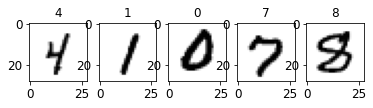

In [130]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item['image']
    labels = item['label']
    for index in range(5):
        plt.subplot(1,5,index+1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image,cmap='binary')
        plt.title(label)
        plt.axis='off'
    break


In [131]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


## TensorFlow Hub

In [133]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_1 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [134]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])
embeddings = hub_layer(sentences)

In [135]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       